# Add all necessary libraries!

In [4]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob
import warnings
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
datasetFolderName=r'D:/FinalProject/DS'
MODEL_FILENAME=r'D:/FinalProject/model_cv.h5'
sourceFiles=[]
classLabels=['CNV', 'DME', 'DRUSEN','NORMAL']
X=[]
Y=[]

img_rows, img_cols =  160, 160 # input image dimensions
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

In [8]:
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score


In [6]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)

In [7]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

In [8]:
X=np.asarray(X)
Y=np.asarray(Y)

In [9]:
PARAMS = {'img_dims': 160,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }

In [8]:
# Note that, this model structure is a very basic one. To achieve better performance, you should change the model structure and hyperparameters according to your needs and data.
batch_size = 32
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=4, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# **Stratified K-Fold Cross validation**

In [13]:
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      zoom_range = 0.3,
                      horizontal_flip = True)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(160,160),
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(160, 160),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)   
   
    # fit model
    history=model.fit_generator(
             train_generator, 
             epochs=PARAMS['epochs'],           
             validation_data=validation_generator)

Results for fold 1
Found 66787 images belonging to 4 classes.
Found 16697 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2088 steps, validate for 522 steps
Epoch 1/10
2088/2088 [==============================] - 2005s 960ms/step - loss: 0.4246 - accuracy: 0.8608 - val_loss: 0.4136 - val_accuracy: 0.8530
Epoch 2/10
2088/2088 [==============================] - 2192s 1s/step - loss: 0.3565 - accuracy: 0.8853 - val_loss: 0.3047 - val_accuracy: 0.9139
Epoch 3/10
2088/2088 [==============================] - 2138s 1s/step - loss: 0.3252 - accuracy: 0.8972 - val_loss: 0.4827 - val_accuracy: 0.8366
Epoch 4/10
2088/2088 [==============================] - 2077s 995ms/step - loss: 0.3101 - accuracy: 0.9019 - val_loss: 3.6582 - val_accuracy: 0.1792
Epoch 5/10
2088/2088 [==============================] - 1924s 922ms/step - loss: 0.2957 - accuracy: 0.9077 - val_loss: 0.3917 - val_accuracy: 0.8797
Epoch 6/10
2088/2088 [==============================] - 1921s

Epoch 6/10
2088/2088 [==============================] - 1853s 887ms/step - loss: 0.2089 - accuracy: 0.9350 - val_loss: 0.1486 - val_accuracy: 0.9517
Epoch 7/10
2088/2088 [==============================] - 1871s 896ms/step - loss: 0.2070 - accuracy: 0.9366 - val_loss: 0.1929 - val_accuracy: 0.9332
Epoch 8/10
2088/2088 [==============================] - 1859s 890ms/step - loss: 0.2062 - accuracy: 0.9373 - val_loss: 0.1549 - val_accuracy: 0.9503
Epoch 9/10
2088/2088 [==============================] - 1858s 890ms/step - loss: 0.2035 - accuracy: 0.9378 - val_loss: 0.1757 - val_accuracy: 0.9439
Epoch 10/10
2088/2088 [==============================] - 1861s 891ms/step - loss: 0.2054 - accuracy: 0.9377 - val_loss: 0.1512 - val_accuracy: 0.9531


# Test phase

In [14]:
model.save('5fold.h5')

In [16]:
import matplotlib.pyplot as plt

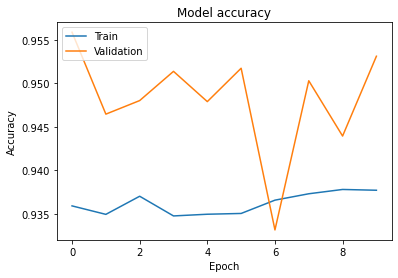

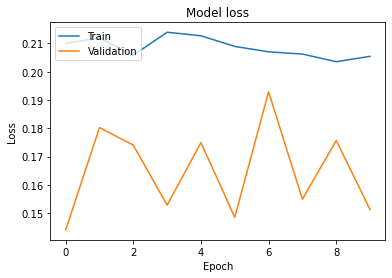

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
print("==============TEST RESULTS============")
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(160, 160),
        batch_size=20,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

==============TEST RESULTS============
Found 1000 images belonging to 4 classes.
50/50 [==============================] - 6s 124ms/step
Accuracy  : 0.989
Precision : 0.9894636015325671
f1Score : 0.9890525705307036
[[250   0   0   0]
 [  4 246   0   0]
 [  7   0 243   0]
 [  0   0   0 250]]


In [1]:
from tensorflow.keras.models import load_model
model = load_model('5fold.h5')

In [2]:
from sklearn.metrics import classification_report

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
        

In [9]:
print("==============TEST RESULTS============")
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(160, 160),
        batch_size=20,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

==============TEST RESULTS============
Found 1000 images belonging to 4 classes.
50/50 [==============================] - 6s 127ms/step
Accuracy  : 0.989
Precision : 0.9894636015325671
f1Score : 0.9890525705307036
[[250   0   0   0]
 [  4 246   0   0]
 [  7   0 243   0]
 [  0   0   0 250]]


In [10]:
print(classification_report(yPredictions,true_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       261
           1       0.98      1.00      0.99       246
           2       0.97      1.00      0.99       243
           3       1.00      1.00      1.00       250

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [11]:
print(yPredictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 

In [15]:
for i in yPredictions:
    if yPredictions[i]!=true_classes[i]:
        print(int(i))

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [38]:
x = np.array([[250 ,  0,   0,   0],
 [  4 ,246,   0,   0],
 [  7  , 0 ,243   ,0],
 [  0   ,0,   0 ,250]])
fig = sns.heatmap(x, annot = True)
heatmap = fig.get_figure()
heatmap.savefig('heatmap.png', dpi = 400)

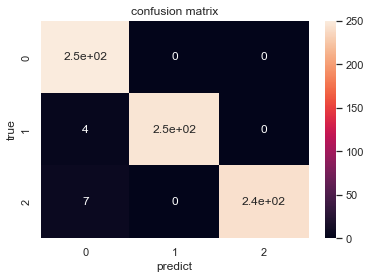

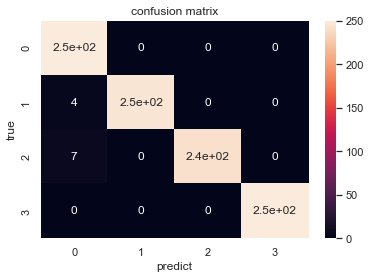

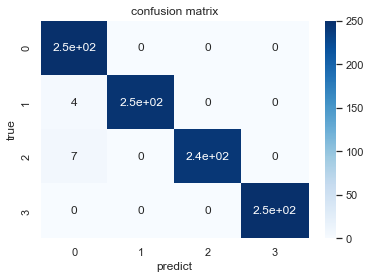

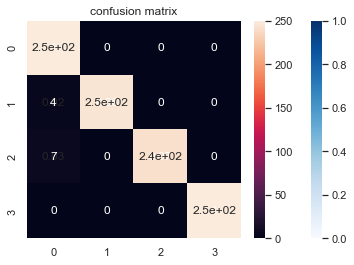

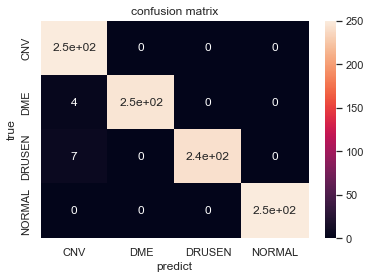

In [39]:
sns.set()
fig = plt.figure()
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(true_classes, yPredictions)
sns.heatmap(conf_mat,annot=True,xticklabels=['CNV','DME','DRUSEN','NORMAL'],yticklabels=['CNV','DME','DRUSEN','NORMAL']) #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.show()
